In [ ]:
from __future__ import annotations

import warnings
from time import perf_counter

import matplotlib.pyplot as plt
from mp_api.client import MPRester
from tqdm import tqdm

from matcalc import ElasticityCalc, EOSCalc, PESCalculator, PhononCalc, RelaxCalc

warnings.filterwarnings("ignore", category=UserWarning, module="matgl")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="spglib")

In [ ]:
mp_data = MPRester().materials.summary.search(
    formula=["LiCl", "NaCl"], fields=["material_id", "structure"], num_chunks=1, chunk_size=10
)

Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
models = [(name, PESCalculator.load_universal(name)) for name in ("M3GNet", "CHGNet")]

In [ ]:
fmax = 0.1
opt = "BFGSLineSearch"

In [ ]:
prop_preds = []

for dct in (pbar := tqdm(mp_data[:10])):  # Here we just do a sampling of 20 structures.
    mat_id, formula = dct.material_id, dct.structure.formula
    pbar.set_description(f"Running {mat_id} ({formula})")
    model_preds = {"material_id": mat_id, "formula": formula, "nsites": len(dct.structure)}

    for model_name, model in models:
        # The general principle is to do a relaxation first and just reuse the same structure.
        prop_calcs = [
            ("relax", RelaxCalc(model, fmax=fmax, optimizer=opt)),
            ("elastic", ElasticityCalc(model, fmax=fmax, relax_structure=False)),
            ("eos", EOSCalc(model, fmax=fmax, relax_structure=False, optimizer=opt)),
            ("phonon", PhononCalc(model, fmax=fmax, relax_structure=False)),
        ]
        properties = {}
        for name, prop_calc in prop_calcs:
            start_time = perf_counter()
            properties[name] = prop_calc.calc(dct.structure)
            if name == "relax":
                # Replace the structure with the one from relaxation for other property computations.
                struct = properties[name]["final_structure"]
            model_preds[f"time_{name}_{model_name}"] = perf_counter() - start_time
        model_preds[model_name] = properties
    prop_preds.append(model_preds)

Running mp-1120767 (Na6 Cl6):   0%|                                                                                                                                    | 0/5 [00:00<?, ?it/s]/Users/shyue/miniconda3/envs/mavrl/lib/python3.11/site-packages/phonopy/structure/cells.py:1482: UserWarning: Crystal structure is distorted in a tricky way so that phonopy could not handle the crystal symmetry properly. It is recommended to symmetrize crystal structure well and then re-start phonon calculation from scratch.
  perm_between = _compute_permutation_c(sorted_a, sorted_b, lattice, symprec)
/Users/shyue/miniconda3/envs/mavrl/lib/python3.11/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
/Users/shyue/miniconda3/envs/mavrl/lib/python3.11/site-packages/phonopy/structure/cells.py:1482: UserWarning: Crystal structure is distorted in a tricky way so that phonopy could not handle the crystal symmetry properly

In [ ]:
import pandas as pd

df_preds = pd.DataFrame(prop_preds)
for model_name, _ in models:
    df_preds[f"time_total_{model_name}"] = (
        df_preds[f"time_relax_{model_name}"]
        + df_preds[f"time_elastic_{model_name}"]
        + df_preds[f"time_phonon_{model_name}"]
        + df_preds[f"time_eos_{model_name}"]
    )

In [ ]:
df_preds

,material_id,formula,nsites,time_relax_M3GNet,time_elastic_M3GNet,time_eos_M3GNet,time_phonon_M3GNet,M3GNet,time_relax_CHGNet,time_elastic_CHGNet,time_eos_CHGNet,time_phonon_CHGNet,CHGNet,time_total_M3GNet,time_total_CHGNet
0,mp-1120767,Na6 Cl6,12,0.135454,3.053201,1.598205,2.911434,{'relax': {'final_structure': [[-2.27515821 3...,0.342480,7.674351,2.772426,3.912949,{'relax': {'final_structure': [[-2.27515821 3...,7.698293,14.702205
1,mp-22851,Na1 Cl1,2,0.027752,0.355090,0.136402,0.453617,"{'relax': {'final_structure': [[0. 0. 0.] Na, ...",0.109993,0.994192,0.363952,0.706294,"{'relax': {'final_structure': [[0. 0. 0.] Na, ...",0.972861,2.174431
2,mp-22862,Na1 Cl1,2,0.040585,0.323761,0.137622,0.522284,{'relax': {'final_structure': [[2.23230856e-07...,0.136384,0.901810,0.352454,0.747818,{'relax': {'final_structure': [[-8.15455981e-0...,1.024252,2.138466
3,mp-1185319,Li2 Cl2,4,0.022864,0.568282,0.201292,2.356742,{'relax': {'final_structure': [[0. 0. ...,0.055026,1.256125,0.477806,2.971281,{'relax': {'final_structure': [[0. 0. ...,3.149180,4.760239
4,mp-22905,Li1 Cl1,2,0.039179,0.377370,0.150175,0.655296,{'relax': {'final_structure': [[ 9.82945868e-0...,0.205040,1.170390,0.441206,0.807996,{'relax': {'final_structure': [[-6.67281562e-0...,1.222021,2.624632


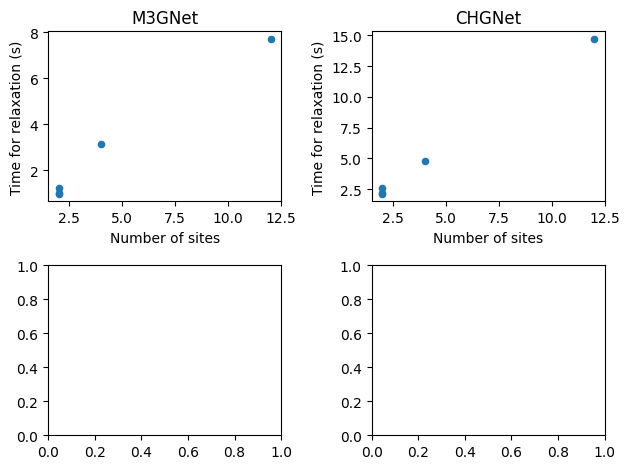

In [ ]:
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
for i, (model_name, model) in enumerate(models):
    ax = axes[i]
    df_preds.plot(x="nsites", y=f"time_total_{model_name}", kind="scatter", ax=ax)
    ax.set_xlabel("Number of sites")
    ax.set_ylabel("Time for relaxation (s)")
    ax.set_title(model_name)

plt.tight_layout()
plt.show()

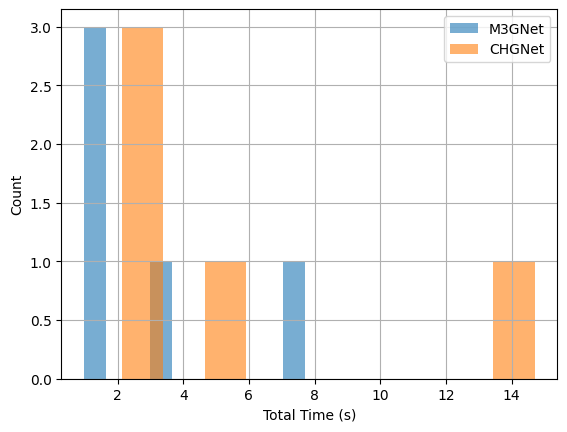

In [ ]:
for model_name, _ in models[:2]:
    ax = df_preds[f"time_total_{model_name}"].hist(label=model_name, alpha=0.6)

ax.set_xlabel("Total Time (s)")
ax.set_ylabel("Count")
ax.legend()
plt.show()